# 1. Загрузка данных

In [ ]:
# Подключаем нужные библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision.utils as vutils
import zipfile
import os
import matplotlib.pyplot as plt

In [ ]:
# Распаковка данных
zip_file = '/content/drive/MyDrive/Pokemon_data/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
print(os.listdir())

['.config', 'drive', 'images', 'sample_data']


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Гиперпараметры и выгрузка данных
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 16
FEATURES_GEN = 16
DISC_ITERATIONS = 5
LAMBDA_GP = 10
dataroot = '/content/images'

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

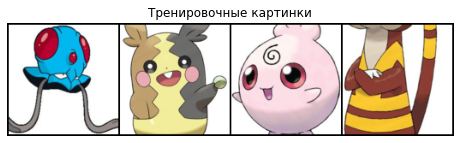

In [ ]:
# Распечатаем несколько тренировочных картинок
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Тренировочные картинки")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

# Описание модели
Для обучения будем использовать Wasserstein-GAN с Gradient Penalty

In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 32, 4, 1, 0),  
            self._block(features_g * 32, features_g * 16, 4, 2, 1),  
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [ ]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
gen.train()
disc.train()

for epoch in range(740, 1000):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        for _ in range(DISC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake).view(-1)
            gp = gradient_penalty(disc, real, fake, device=device)
            loss_disc = (
                -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP * gp
            )
            disc.zero_grad()
            loss_disc.backward(retain_graph=True)
            opt_disc.step()

        gen_fake = disc(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(
          f"Epoch [{epoch}/1000] \
          Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
      )
    if (epoch % 20 == 0):
        with torch.no_grad():
            save_checkpoint(gen.state_dict(), '/content/drive/MyDrive/model_pokemon/gen_'+str(epoch)+'.pth')
            save_checkpoint(disc.state_dict(), '/content/drive/MyDrive/model_pokemon/disc_'+str(epoch)+'.pth')
            save_checkpoint(opt_disc.state_dict(), '/content/drive/MyDrive/model_pokemon/opt_disc_'+str(epoch)+'.pth')
            save_checkpoint(opt_gen.state_dict(), '/content/drive/MyDrive/model_pokemon/opt_gen_'+str(epoch)+'.pth')

Epoch [715/1000]           Loss D: -112.6434, loss G: 1057.0577
Epoch [716/1000]           Loss D: -92.2940, loss G: 982.7302
Epoch [717/1000]           Loss D: -116.0076, loss G: 995.0717
Epoch [718/1000]           Loss D: -117.8968, loss G: 1021.0743
Epoch [719/1000]           Loss D: -145.2300, loss G: 1011.9940
Epoch [720/1000]           Loss D: -108.9489, loss G: 1070.9885
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch [721/1000]           Loss D: -116.5162, loss G: 1039.2539
Epoch [722/1000]           Loss D: -129.9528, loss G: 1001.7992
Epoch [723/1000]           Loss D: -121.7892, loss G: 1061.8911
Epoch [724/1000]           Loss D: -111.7012, loss G: 1034.5845
Epoch [725/1000]           Loss D: -128.7148, loss G: 1004.3116
Epoch [726/1000]           Loss D: -116.8955, loss G: 1045.7888
Epoch [727/1000]           Loss D: -124.5868, loss G: 1033.6055
Epoch [728/1000]           Loss D: -124.4593, loss G: 981.8706
Epoch [729/1000]        

In [ ]:
state_disc = torch.load('/content/drive/MyDrive/model_pokemon/disc_720.pth', map_location=device)
state_gen = torch.load('/content/drive/MyDrive/model_pokemon/gen_720.pth', map_location=device)
state_opt_disc = torch.load('/content/drive/MyDrive/model_pokemon/opt_disc_720.pth', map_location=device)
state_opt_gen = torch.load('/content/drive/MyDrive/model_pokemon/opt_gen_720.pth', map_location=device)

gen.load_state_dict(state_gen)
disc.load_state_dict(state_disc)
opt_disc.load_state_dict(state_opt_disc)
opt_gen.load_state_dict(state_opt_gen)

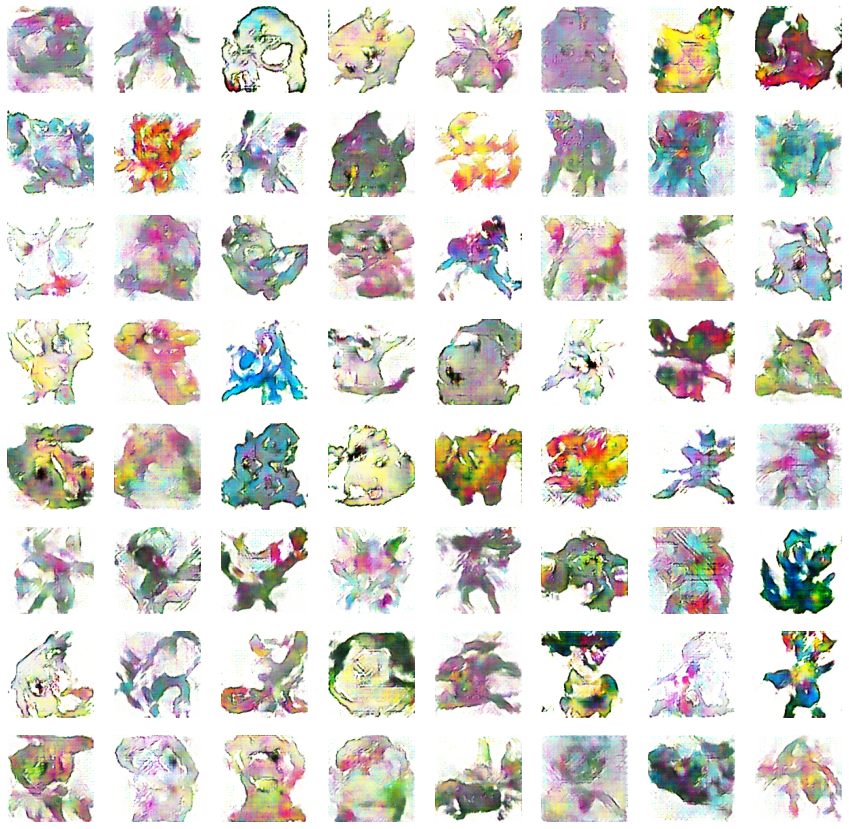

In [ ]:
bs_s=64
plt.figure(figsize=[15,15])
noize=torch.randn(128, 100, 1, 1).to(device)
samples=gen(noize)
samples=samples*0.5+0.5
for i in range(bs_s):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

#Смена модели из-за переобучения
Решено перейти на модель AEGAN, при этом использовать поворот изображений для обучения, использовать меньшее латентное пространство.

In [ ]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

In [ ]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    

In [ ]:
EPS = 1e-6
ALPHA_RECONSTRUCT_IMAGE = 1
ALPHA_RECONSTRUCT_LATENT = 0.5
ALPHA_DISCRIMINATE_IMAGE = 0.005
ALPHA_DISCRIMINATE_LATENT = 0.1

class Generator(nn.Module):

    def __init__(self, latent_dim: int = 8):
        super().__init__()
        self.latent_dim = latent_dim
        self._init_modules()

    def build_colourspace(self, input_dim: int, output_dim: int):
        colourspace = nn.Sequential(
            nn.Linear(
                input_dim,
                128,
                bias=True),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(
                128,
                64,
                bias=True),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.Linear(
                64,
                output_dim,
                bias=True),
            nn.Tanh(),
            )
        return colourspace

    def _init_modules(self):
        projection_widths = [8, 8, 8, 8, 8, 8, 8]
        self.projection_dim = sum(projection_widths) + self.latent_dim
        self.projection = nn.ModuleList()
        for index, i in enumerate(projection_widths):
            self.projection.append(
                nn.Sequential(
                    nn.Linear(
                        self.latent_dim + sum(projection_widths[:index]),
                        i,
                        bias=True,
                        ),
                    nn.BatchNorm1d(8),
                    nn.LeakyReLU(),
                    )
                )
        self.projection_upscaler = nn.Upsample(scale_factor=3)

        self.colourspace_r = self.build_colourspace(self.projection_dim, 16)
        self.colourspace_g = self.build_colourspace(self.projection_dim, 16)
        self.colourspace_b = self.build_colourspace(self.projection_dim, 16)
        self.colourspace_upscaler = nn.Upsample(scale_factor=96)

        self.seed = nn.Sequential(
            nn.Linear(
                self.projection_dim,
                512*3*3,
                bias=True),
            nn.BatchNorm1d(512*3*3),
            nn.LeakyReLU(),
            )

        self.upscaling = nn.ModuleList()
        self.conv = nn.ModuleList()

        self.upscaling.append(nn.Upsample(scale_factor=2))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(
                in_channels=(512)//4,
                out_channels=512,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            ))

        self.upscaling.append(nn.Upsample(scale_factor=2))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=(512 + self.projection_dim)//4,
                out_channels=256,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            ))

        self.upscaling.append(nn.Upsample(scale_factor=2))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=(256 + self.projection_dim)//4,
                out_channels=256,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            ))

        self.upscaling.append(nn.Upsample(scale_factor=2))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=(256 + self.projection_dim)//4,
                out_channels=256,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            )),

        self.upscaling.append(nn.Upsample(scale_factor=2))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(
                in_channels=(256 + self.projection_dim)//4,
                out_channels=64,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            ))

        self.upscaling.append(nn.Upsample(scale_factor=1))
        self.conv.append(nn.Sequential(
            nn.ZeroPad2d((2, 2, 2, 2)),
            nn.Conv2d(
                in_channels=64,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=0,
                bias=True
                ),
            nn.Softmax(dim=1),
            ))

    def forward(self, input_tensor):
        last = input_tensor
        for module in self.projection:
            projection = module(last)
            last = torch.cat((last, projection), -1)
        projection = last

        intermediate = self.seed(projection)
        intermediate = intermediate.view((-1, 512, 3, 3))

        projection_2d = projection.view((-1, self.projection_dim, 1, 1))
        projection_2d = self.projection_upscaler(projection_2d)

        for i, (conv, upscaling) in enumerate(zip(self.conv, self.upscaling)):
            if i + 1 != len(self.upscaling):
                if i > 0:
                    intermediate = torch.cat((intermediate, projection_2d), 1)
                intermediate = torch.nn.functional.pixel_shuffle(intermediate, 2)
            intermediate = conv(intermediate)
            projection_2d = upscaling(projection_2d)

        r_space = self.colourspace_r(projection)
        r_space = r_space.view((-1, 16, 1, 1))
        r_space = self.colourspace_upscaler(r_space)
        r_space = intermediate * r_space
        r_space = torch.sum(r_space, dim=1, keepdim=True)

        g_space = self.colourspace_g(projection)
        g_space = g_space.view((-1, 16, 1, 1))
        g_space = self.colourspace_upscaler(g_space)
        g_space = intermediate * g_space
        g_space = torch.sum(g_space, dim=1, keepdim=True)

        b_space = self.colourspace_b(projection)
        b_space = b_space.view((-1, 16, 1, 1))
        b_space = self.colourspace_upscaler(b_space)
        b_space = intermediate * b_space
        b_space = torch.sum(b_space, dim=1, keepdim=True)

        output = torch.cat((r_space, g_space, b_space), dim=1)

        return output


class Encoder(nn.Module):


    def __init__(self, device: str = "cpu", latent_dim: int = 8):

        super().__init__()
        self.device = device
        self.latent_dim = latent_dim
        self._init_modules()

    def _init_modules(self):
  
        down_channels = [3, 64, 128, 256, 512]
        self.down = nn.ModuleList()
        for i in range(len(down_channels)-1):
            self.down.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=down_channels[i],
                        out_channels=down_channels[i+1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        bias=True,
                        ),
                    nn.BatchNorm2d(down_channels[i+1]),
                    nn.LeakyReLU(),
                    )
                )

        self.reducer = nn.Sequential(
            nn.Conv2d(
                in_channels=down_channels[-1],
                out_channels=down_channels[-2],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
                ),
            nn.BatchNorm2d(down_channels[-2]),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2)
            )

        up_channels = [256, 128, 64, 64, 64]
        scale_factors = [2, 2, 2, 1]
        self.up = nn.ModuleList()
        for i in range(len(up_channels)-1):
            self.up.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=up_channels[i] + down_channels[-2-i],
                        out_channels=up_channels[i+1],
                        kernel_size=3,
                        stride=1,
                        padding=1,
                        bias=True,
                        ),
                    nn.BatchNorm2d(up_channels[i+1]),
                    nn.LeakyReLU(),
                    nn.Upsample(scale_factor=scale_factors[i]),
                    )
                )

        down_again_channels = [64+3, 64, 64, 64, 64]
        self.down_again = nn.ModuleList()
        for i in range(len(down_again_channels)-1):
            self.down_again.append(
                nn.Conv2d(
                    in_channels=down_again_channels[i],
                    out_channels=down_again_channels[i+1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                    )
                )
            self.down_again.append(nn.BatchNorm2d(down_again_channels[i+1]))
            self.down_again.append(nn.LeakyReLU())

        self.projection = nn.Sequential(
            nn.Linear(
                512*6*6 + 64*6*6,
                256,
                bias=True,
                ),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            nn.Linear(
                256,
                128,
                bias=True,
                ),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(
                128,
                self.latent_dim,
                bias=True,
                ),
            )

    def forward(self, input_tensor):
        rv = torch.randn(input_tensor.size(), device=self.device) * 0.02
        augmented_input = input_tensor + rv
        intermediate = augmented_input
        intermediates = [augmented_input]
        for module in self.down:
            intermediate = module(intermediate)
            intermediates.append(intermediate)
        intermediates = intermediates[:-1][::-1]

        down = intermediate.view(-1, 6*6*512)

        intermediate = self.reducer(intermediate)

        for index, module in enumerate(self.up):
            intermediate = torch.cat((intermediate, intermediates[index]), 1)
            intermediate = module(intermediate)

        intermediate = torch.cat((intermediate, input_tensor), 1)

        for module in self.down_again:
            intermediate = module(intermediate)

        intermediate = intermediate.view(-1, 6*6*64)
        intermediate = torch.cat((down, intermediate), -1)

        projected = self.projection(intermediate)

        return projected


class DiscriminatorImage(nn.Module):

    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device
        self._init_modules()

    def _init_modules(self):
        down_channels = [3, 64, 128, 256, 512]
        self.down = nn.ModuleList()
        leaky_relu = nn.LeakyReLU()
        for i in range(4):
            self.down.append(
                nn.Conv2d(
                    in_channels=down_channels[i],
                    out_channels=down_channels[i+1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                    )
                )
            self.down.append(nn.BatchNorm2d(down_channels[i+1]))
            self.down.append(leaky_relu)

        self.classifier = nn.ModuleList()
        self.width = down_channels[-1] * 6**2
        self.classifier.append(nn.Linear(self.width, 1))
        self.classifier.append(nn.Sigmoid())

    def forward(self, input_tensor):
        rv = torch.randn(input_tensor.size(), device=self.device) * 0.02
        intermediate = input_tensor + rv
        for module in self.down:
            intermediate = module(intermediate)
            rv = torch.randn(intermediate.size(), device=self.device) * 0.02 + 1
            intermediate *= rv

        intermediate = intermediate.view(-1, self.width)

        for module in self.classifier:
            intermediate = module(intermediate)

        return intermediate


class DiscriminatorLatent(nn.Module):

    def __init__(self, latent_dim=8, device="cpu"):
        super().__init__()
        self.latent_dim = latent_dim
        self.device = device
        self._init_modules()

    def _init_modules(self, depth=7, width=8):
        self.pyramid = nn.ModuleList()
        for i in range(depth):
            self.pyramid.append(
                nn.Sequential(
                    nn.Linear(
                        self.latent_dim + width*i,
                        width,
                        bias=True,
                        ),
                    nn.BatchNorm1d(width),
                    nn.LeakyReLU(),
                    )
                )

        self.classifier = nn.ModuleList()
        self.classifier.append(nn.Linear(depth*width + self.latent_dim, 1))
        self.classifier.append(nn.Sigmoid())

    def forward(self, input_tensor):
        last = input_tensor
        for module in self.pyramid:
            projection = module(last)
            rv = torch.randn(projection.size(), device=self.device) * 0.02 + 1
            projection *= rv
            last = torch.cat((last, projection), -1)
        for module in self.classifier:
            last = module(last)
        return last


class AEGAN():

    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cpu'):
        assert latent_dim % 4 == 0
        self.latent_dim = latent_dim
        self.device = device
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size

        self.criterion_gen = nn.BCELoss()
        self.criterion_recon_image = nn.L1Loss()
        self.criterion_recon_latent = nn.MSELoss()
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)
        self._init_generator()
        self._init_encoder()
        self._init_dx()
        self._init_dz()

    def _init_generator(self):
        self.generator = Generator(latent_dim=self.latent_dim)
        self.generator = self.generator.to(self.device)
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=2e-4, betas=(0.5, 0.999),
                                  weight_decay=1e-8)

    def _init_encoder(self):
        self.encoder = Encoder(latent_dim=self.latent_dim, device=self.device)
        self.encoder = self.encoder.to(self.device)
        self.optim_e = optim.Adam(self.encoder.parameters(),
                                  lr=2e-4, betas=(0.5, 0.999),
                                  weight_decay=1e-8)

    def _init_dx(self):
        self.discriminator_image = DiscriminatorImage(device=self.device).to(self.device)
        self.optim_di = optim.Adam(self.discriminator_image.parameters(),
                                   lr=1e-4, betas=(0.5, 0.999),
                                   weight_decay=1e-8)

    def _init_dz(self):
        self.discriminator_latent = DiscriminatorLatent(
            latent_dim=self.latent_dim,
            device=self.device,
            ).to(self.device)
        self.optim_dl = optim.Adam(self.discriminator_latent.parameters(),
                                   lr=1e-4, betas=(0.5, 0.999),
                                   weight_decay=1e-8)


    def generate_samples(self, latent_vec=None, num=None):
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generators(self, X):
        self.generator.zero_grad()
        self.encoder.zero_grad()

        Z = self.noise_fn(self.batch_size)

        X_hat = self.generator(Z)
        Z_hat = self.encoder(X)
        X_tilde = self.generator(Z_hat)
        Z_tilde = self.encoder(X_hat)

        X_hat_confidence = self.discriminator_image(X_hat)
        Z_hat_confidence = self.discriminator_latent(Z_hat)
        X_tilde_confidence = self.discriminator_image(X_tilde)
        Z_tilde_confidence = self.discriminator_latent(Z_tilde)

        X_hat_loss = self.criterion_gen(X_hat_confidence, self.target_ones)
        Z_hat_loss = self.criterion_gen(Z_hat_confidence, self.target_ones)
        X_tilde_loss = self.criterion_gen(X_tilde_confidence, self.target_ones)
        Z_tilde_loss = self.criterion_gen(Z_tilde_confidence, self.target_ones)

        X_recon_loss = self.criterion_recon_image(X_tilde, X) * ALPHA_RECONSTRUCT_IMAGE
        Z_recon_loss = self.criterion_recon_latent(Z_tilde, Z) * ALPHA_RECONSTRUCT_LATENT

        X_loss = (X_hat_loss + X_tilde_loss) / 2 * ALPHA_DISCRIMINATE_IMAGE
        Z_loss = (Z_hat_loss + Z_tilde_loss) / 2 * ALPHA_DISCRIMINATE_LATENT
        loss = X_loss + Z_loss + X_recon_loss + Z_recon_loss

        loss.backward()
        self.optim_e.step()
        self.optim_g.step()

        return X_loss.item(), Z_loss.item(), X_recon_loss.item(), Z_recon_loss.item()

    def train_step_discriminators(self, X):
        self.discriminator_image.zero_grad()
        self.discriminator_latent.zero_grad()

        Z = self.noise_fn(self.batch_size)

        with torch.no_grad():
            X_hat = self.generator(Z)
            Z_hat = self.encoder(X)
            X_tilde = self.generator(Z_hat)
            Z_tilde = self.encoder(X_hat)

        X_confidence = self.discriminator_image(X)
        X_hat_confidence = self.discriminator_image(X_hat)
        X_tilde_confidence = self.discriminator_image(X_tilde)
        Z_confidence = self.discriminator_latent(Z)
        Z_hat_confidence = self.discriminator_latent(Z_hat)
        Z_tilde_confidence = self.discriminator_latent(Z_tilde)

        X_loss = 2 * self.criterion_gen(X_confidence, self.target_ones)
        X_hat_loss = self.criterion_gen(X_hat_confidence, self.target_zeros)
        X_tilde_loss = self.criterion_gen(X_tilde_confidence, self.target_zeros)
        Z_loss = 2 * self.criterion_gen(Z_confidence, self.target_ones)
        Z_hat_loss = self.criterion_gen(Z_hat_confidence, self.target_zeros)
        Z_tilde_loss = self.criterion_gen(Z_tilde_confidence, self.target_zeros)

        loss_images = (X_loss + X_hat_loss + X_tilde_loss) / 4
        loss_latent = (Z_loss + Z_hat_loss + Z_tilde_loss) / 4
        loss = loss_images + loss_latent

        loss.backward()
        self.optim_di.step()
        self.optim_dl.step()

        return loss_images.item(), loss_latent.item()

    def train_epoch(self, print_frequency=1, max_steps=0):
        ldx, ldz, lgx, lgz, lrx, lrz = 0, 0, 0, 0, 0, 0
        eps = 1e-9
        for batch, (real_samples, _) in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            ldx_, ldz_ = self.train_step_discriminators(real_samples)
            ldx += ldx_
            ldz += ldz_
            lgx_, lgz_, lrx_, lrz_ = self.train_step_generators(real_samples)
            lgx += lgx_
            lgz += lgz_
            lrx += lrx_
            lrz += lrz_
            if (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={lgx / (eps + (batch+1) * ALPHA_DISCRIMINATE_IMAGE):.3f},"
                      f" E={lgz / (eps + (batch+1) * ALPHA_DISCRIMINATE_LATENT):.3f},"
                      f" Dx={ldx / (eps + (batch+1)):.3f},"
                      f" Dz={ldz / (eps + (batch+1)):.3f}",
                      f" Rx={lrx / (eps + (batch+1) * ALPHA_RECONSTRUCT_IMAGE):.3f}",
                      f" Rz={lrz / (eps + (batch+1) * ALPHA_RECONSTRUCT_LATENT):.3f}",
                      end='\r',
                      flush=True)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        lgx /= batch
        lgz /= batch
        ldx /= batch
        ldz /= batch
        lrx /= batch
        lrz /= batch
        return lgx, lgz, ldx, ldz, lrx, lrz

In [ ]:
BATCH_SIZE = 32
LATENT_DIM = 16
EPOCHS = 500
IMAGE_SIZE = 128

device = "cuda" if torch.cuda.is_available() else "cpu"

dataroot = '/content/images'


transform = tv.transforms.Compose([
            tv.transforms.Resize((96, 96)),
            tv.transforms.RandomAffine(0, translate=(5/96, 5/96), fill=(255,255,255)),
            tv.transforms.ColorJitter(hue=0.5),
            tv.transforms.RandomHorizontalFlip(p=0.5),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
            ])
dataset = ImageFolder(
            root=dataroot,
            transform=transform
            )
dataloader = DataLoader(dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True
            )
    

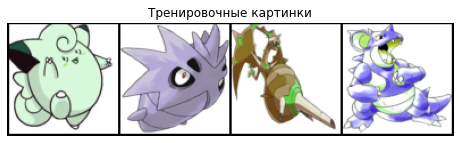

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Тренировочные картинки")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
noise_fn = lambda x: torch.randn((x, LATENT_DIM), device=device)
test_noise = noise_fn(36)
gan = AEGAN(
    LATENT_DIM,
    noise_fn,
    dataloader,
    device=device,
    batch_size=BATCH_SIZE,
)

Тренировка модели

In [ ]:
 for i in range(326, EPOCHS):
    gan.train_epoch(print_frequency=1, max_steps=0)
    print(f"Epoch {i+1}")
    if (i + 1) % 5 == 0:
        save_checkpoint(gan.generator.state_dict(), '/content/drive/MyDrive/pokemon_model/gen_'+str(i+1)+'.pth')


Epoch 324

Epoch 325
=> Saving checkpoint

Epoch 326

Epoch 327

Epoch 328

Epoch 329

Epoch 330
=> Saving checkpoint

Epoch 331

Epoch 332

Epoch 333

Epoch 334

Epoch 335
=> Saving checkpoint

Epoch 336

Epoch 337


Загрузка модели:

In [ ]:
state_gen = torch.load('/content/drive/MyDrive/pokemon_model/gen_320.pth', map_location=device)
gan.generator.load_state_dict(state_gen)

<All keys matched successfully>

Полученные результаты:

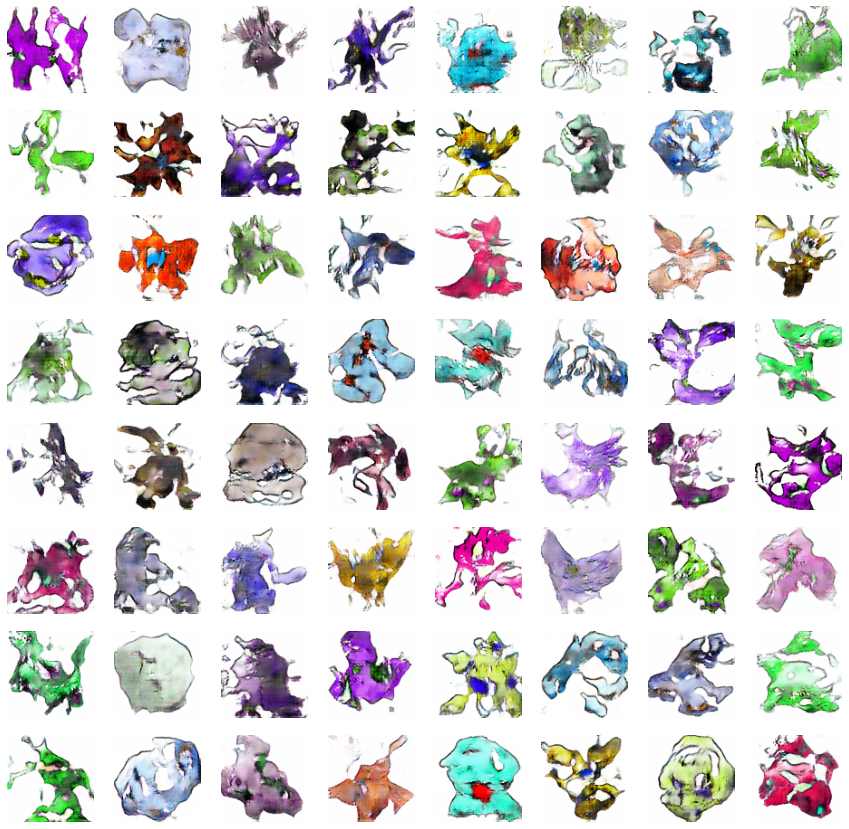

In [ ]:
    images = gan.generate_samples(num=64)
    plt.figure(figsize=[15,15])
    plt.title("Полученые результаты")
    for i in range(64):
      plt.subplot(8, 8, i+1)
      plt.axis("off")
      plt.imshow(np.transpose(vutils.make_grid(images[i].to(device), padding=2, normalize=True).cpu(),(1,2,0)))